In [5]:
# 셀 1

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from tqdm import tqdm

# 한글 폰트 설정 (옵션)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [6]:
def custom_linear_interpolation(series):
    """
    [커스텀 1차 스플라인(선형) 보간 함수]
    ---------------------------------------
    1) datetime 인덱스를 int64(ns)로 변환
    2) bounds_error=False, fill_value=(처음 유효값, 마지막 유효값) 설정
       - 시리즈 맨 앞 결측치는 '첫 유효값'으로 채우고
       - 시리즈 맨 뒤 결측치는 '마지막 유효값'으로 채운다.
    3) 그 외 구간은 1차 스플라인(선형) 보간
    4) 음수값 발생 시 0으로 치환
    """
    valid_idx = series.index[series.notna()]       # 유효값의 인덱스
    valid_values = series.dropna().values          # 유효값들의 실제 값
    
    # 유효 데이터가 1개 이하라면, 보간 의미가 거의 없으므로 그대로 반환
    if len(valid_idx) <= 1:
        return series.fillna(valid_values[0] if len(valid_values) == 1 else np.nan)
    
    # (1) datetime → int64 (ns 단위)로 변환
    x_valid = valid_idx.astype("int64")
    x_new = series.index.astype("int64")
    
    # (2) 1차 보간기 생성
    #     bounds_error=False 를 사용해 주어진 x 범위 밖도 에러 없이 처리
    #     fill_value=(valid_values[0], valid_values[-1])로 앞뒤를 채운다.
    f = interp1d(
        x_valid,
        valid_values,
        kind='linear',
        bounds_error=False,
        fill_value=(valid_values[0], valid_values[-1])
    )
    
    # (3) 전체 인덱스에 대해 보간
    filled_series = series.copy()
    filled_series[:] = f(x_new)
    
    # (4) 음수값을 0으로 치환
    filled_series[filled_series < 0] = 0
    
    return filled_series

def moving_average(series, window=3):
    """
    주어진 시계열 데이터에 이동 평균(rolling mean)을 적용합니다.
    
    Parameters:
    - series : pd.Series
    - window : int, 이동 평균 창 크기 (기본값: 3)
    
    Returns:
    - 이동 평균이 적용된 pd.Series
    """
    return series.rolling(window=window, center=True, min_periods=1).mean()

def fill_missing_data(series, window=3):
    """
    [최종: 1차 스플라인(선형) + 이동 평균]
    ------------------------------------
    1) custom_linear_interpolation()으로 먼저 보간
    2) 이동 평균(rolling mean)을 적용하여 평활화
    3) 이동 평균 후 음수 발생 시 0으로 재치환
    """
    # (1) 커스텀 1차 스플라인(선형) 보간
    interpolated = custom_linear_interpolation(series)
    
    # (2) 이동 평균으로 평활화
    smoothed = moving_average(interpolated, window=window)
    
    # (3) 평활화 후 음수값 0으로 치환
    smoothed[smoothed < 0] = 0
    
    return smoothed

def fill_missing_data_df(df, 
                         time_col='시간', 
                         region_col='동', 
                         item_col='품목', 
                         price_col='가격', 
                         window=3):
    """
    DataFrame 내 (동, 품목)별로 시간 순으로 정렬 후,
    '가격' 컬럼에 대해 custom_linear_interpolation + 이동평균을 적용하여 결측값을 보완합니다.
    tqdm을 사용해 그룹별 진행 상황을 확인합니다.
    
    Parameters:
    - df         : 원본 pd.DataFrame
    - time_col   : 시간 컬럼명 (기본: '시간')
    - region_col : 동(지역) 컬럼명 (기본: '동')
    - item_col   : 품목 컬럼명 (기본: '품목')
    - price_col  : 가격 컬럼명 (기본: '가격')
    - window     : 이동 평균 창 크기 (기본: 3)
    
    Returns:
    - 결측치가 보완된 pd.DataFrame
    """
    # 1) 그룹화 전, 시간 순으로 정렬
    df = df.sort_values([region_col, item_col, time_col])
    filled_df = df.copy()
    
    # 2) (동, 품목) 그룹화
    groups = df.groupby([region_col, item_col])
    total_groups = len(groups)
    
    # 3) 그룹별 보간 & 평활화
    for (region, item), group in tqdm(groups, total=total_groups, desc="결측치 보완 진행"):
        times = group[time_col]
        prices = group[price_col]
        
        # 시계열의 인덱스를 '시간'으로 설정
        series = prices.copy()
        series.index = times
        
        # (1차 스플라인 + 이동 평균) 적용
        filled_series = fill_missing_data(series, window=window)
        
        # 결과 반영
        filled_df.loc[group.index, price_col] = filled_series.values
        
    return filled_df


In [7]:
# (1) 파일 경로 지정
input_file = 'C:\\Users\\delta\\Desktop\\대전_물가_IQR_이상치제거.xlsx'
output_file = 'C:\\Users\\delta\\Desktop\\대전_물가_IQR_이상치제거_결측치보완(커스텀한 1파 스플라인).xlsx'

# (2) 엑셀 파일 읽기 (Wide Format)
df_wide = pd.read_excel(input_file)

# (3) Wide → Long 변환
df_long = df_wide.melt(
    id_vars=['월','품목'],  
    var_name='동',
    value_name='가격'
)

# (4) "월" 컬럼명을 "시간"으로 바꾸고, datetime 형태로 변환
df_long.rename(columns={'월':'시간'}, inplace=True)
df_long['시간'] = pd.to_datetime(df_long['시간'], format='%Y-%m', errors='coerce')

# (5) 보완 전 결측치 확인
missing_count_before = df_long['가격'].isna().sum()
print(f"[보완 전] '가격' 결측치 개수: {missing_count_before} 개")

# (6) (동, 품목)별로 1차 스플라인 + 이동평균 보완
filled_df = fill_missing_data_df(
    df_long, 
    time_col='시간', 
    region_col='동', 
    item_col='품목', 
    price_col='가격', 
    window=3
)

# (7) 보완 후 결측치 확인
missing_count_after = filled_df['가격'].isna().sum()
print(f"[보완 후] '가격' 결측치 개수: {missing_count_after} 개")
print(f"총 {missing_count_before - missing_count_after} 개의 결측치를 보완했습니다.")

# (8) 최종 Long Format 그대로 엑셀에 저장
filled_df.to_excel(output_file, index=False)
print(f"결측치 보완된 Long Format 데이터가 '{output_file}'에 저장되었습니다.")

[보완 전] '가격' 결측치 개수: 16669 개


결측치 보완 진행: 100%|██████████| 740/740 [00:01<00:00, 478.80it/s]


[보완 후] '가격' 결측치 개수: 0 개
총 16669 개의 결측치를 보완했습니다.
결측치 보완된 Long Format 데이터가 'C:\Users\delta\Desktop\대전_물가_IQR_이상치제거_결측치보완(커스텀한 1파 스플라인).xlsx'에 저장되었습니다.


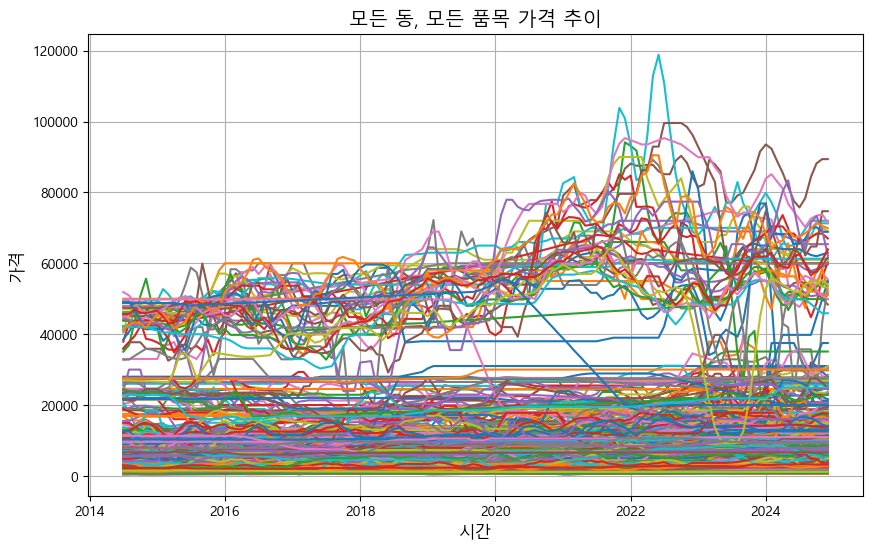

In [8]:
# (1) 사용자 입력 (동/품목)
#    - 둘 다 공백("")이면 전체 데이터를 시각화
selected_region = ''  # 예) '가오동'
selected_item = ''    # 예) '감귤'

# (2) 그림 크기 설정
plt.figure(figsize=(10, 6))

# (3) 조건 분기
# 1) 동만 지정 & 품목은 미지정
if selected_region and not selected_item:
    data_region = filled_df[filled_df['동'] == selected_region]
    for item_name, group_data in data_region.groupby('품목'):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{item_name}")
    plt.title(f"{selected_region} 지역의 모든 품목 가격 추이", fontsize=14)

# 2) 품목만 지정 & 동은 미지정
elif not selected_region and selected_item:
    data_item = filled_df[filled_df['품목'] == selected_item]
    for region_name, group_data in data_item.groupby('동'):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{region_name}")
    plt.title(f"『{selected_item}』 품목의 모든 동 가격 추이", fontsize=14)

# 3) 동과 품목 둘 다 지정
elif selected_region and selected_item:
    plot_data = filled_df[
        (filled_df['동'] == selected_region) & 
        (filled_df['품목'] == selected_item)
    ]
    plot_data = plot_data.sort_values(by='시간')
    plt.plot(plot_data['시간'], plot_data['가격'], label=f"{selected_region} - {selected_item}")
    plt.title(f"[{selected_region} - {selected_item}] 가격 추이", fontsize=14)

# 4) 둘 다 미지정 (전체 시각화)
else:
    # 전체 데이터를 (동, 품목)별로 반복하며 모두 그리기
    for (region_name, item_name), group_data in filled_df.groupby(['동', '품목']):
        group_data = group_data.sort_values(by='시간')
        plt.plot(group_data['시간'], group_data['가격'], label=f"{region_name}-{item_name}")
    plt.title("모든 동, 모든 품목 가격 추이", fontsize=14)

# (4) 공통 설정
plt.xlabel('시간', fontsize=12)
plt.ylabel('가격', fontsize=12)
plt.grid(True)
plt.show()